# NLP milestone project 2: SkimLit 📜🔥

The purpose of this project is to build an NLP model to make reading medical abstracts easier.



In [1]:
from motivation import quotes,quran_ayats
print(f"Quote from Quran : {quran_ayats()}")
print(f'Quote for programmers :{quotes()}')


Quote from Quran : Indeed, He is ever Knowing and Competent.(Quran 35:44)
Quote for programmers :Programmer: A machine that turns coffee into code


## Getting data
we can get data from [here](https://github.com/Franck-Dernoncourt/pubmed-rct.git)

In [2]:
# from helper_functions import unzip_data

# file_name = 'pubmed-rct-master.zip'
# unzip_data(file_name)

# Information of data
Abstract:

PubMed 200k RCT is new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. The purpose of releasing this dataset is twofold. First, the majority of datasets for sequential short-text classification (i.e., classification of short texts that appear in sequences) are small: we hope that releasing a new large dataset will help develop more accurate algorithms for this task. Second, from an application perspective, researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.

In [3]:
# we will start our experiments with 20k dataset with numbers replaced by '@' sign
data_dir = 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/'


In [4]:
# Check all the filenames in the target directory 
import os 

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct-master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data 

lets write a function to read in all lines of a target text file 

In [5]:
# Create function to read the lines of a document 

def get_lines(filename):
    """
    Reads filename and returns the lines of text as a list 
    Args:
    filename : a string containing the target filepath
    Return : 
    A list of string with one string per line from target filename 
    """
    with open(filename,'r') as f:
        return f.readlines()

In [6]:
# lets read in training lines 
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [7]:
len(train_lines)

210040

Lets think about how we want our data to look 
how i think our data would be best represented 

[{ 'line_number' : 0,
  
  'target' : 'BACKGROUND',

  'text' : Emotional eating is associated with overeating and the development of obesity .\n'

  'total_lines' : 11},

.....]



In [8]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples
     

In [9]:
# get data from file and peprocess it 
# %%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')

print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135


In [10]:
# check the frst abstract of our training data 
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is int the format of a list of dictinaries , how about we turn it into a Dataframe to further visualization

In [11]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [12]:
# distributions of labels 
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='target'>

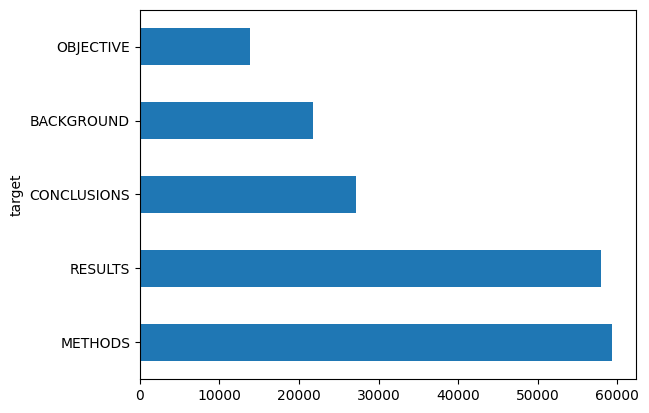

In [13]:

train_df.target.value_counts().plot.barh()

<Axes: ylabel='Frequency'>

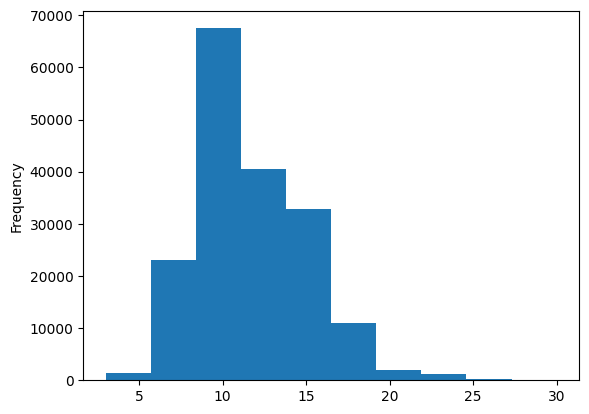

In [14]:
# lets check the length of differnt lines 
train_df.total_lines.plot.hist()

### Get list of sentences 

In [15]:
# convert abstract text lines into lists

train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].tolist()

len(train_sentences) , len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [16]:
# view the 10 lines of training sentences 
train_sentences[:10]


['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric lablels 

In [17]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))

train_labels_one_hot 

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded=  label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get classes names and number of classes from lable encoder instance 

num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes,class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling of experiments 
lets start with baseline 

## Model 0 : Getting a baseline 

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipline 
model_0 = Pipeline([
    ('tf-idf' , TfidfVectorizer()),
    ('clf' , MultinomialNB())
])

model_0.fit(X=  train_sentences,y= train_labels_encoded) # type: ignore

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# evaluate baseline model on validation dataset 

model_0.score(X = val_sentences,y=val_labels_encoded) # type: ignore

0.7218323844829869

In [22]:
# make predicitons using our baseline model 
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
from helper_functions import calculate_results

baseline_results = calculate_results(y_true=val_labels_encoded,y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

In [24]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras import layers # type: ignore

In [25]:
# how long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len.round()

26.0

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

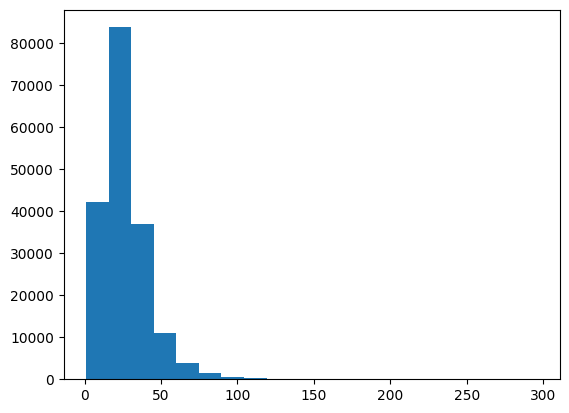

In [26]:
# what is the dstribution look like 

import matplotlib.pyplot as plt
plt.hist(sent_lens,bins = 20)

In [27]:
# how long should a sentence length covers 95 % of examples

output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

## Create a Text vectorizer layer 

In [28]:
max_tokens = 68000

In [29]:
# create text vectorizer 
# import tf.keras.layers.TextVectorization # type: ignore
from tensorflow.keras.layers import TextVectorization 
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = output_seq_len)

In [30]:
# Adapt text vectorizor to training sentences
text_vectorizer.adapt(train_sentences)

In [31]:
# Test out text vectorizer on random sentences 
import random 
target_sentence = random.choice(train_sentences)
print(f'Text: \n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nvectorized text: {text_vectorizer([target_sentence])}')

Text: 
clinical trial registered with www.clinicaltrials.gov ( nct@ and nct@ ) .

Length of text: 11

vectorized text: [[  47   32  394    7 2530  176    3  176    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [32]:
# how many words in our training vocabulary 

rct_20k_text_vocab = text_vectorizer.get_vocabulary()

print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')


Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [33]:
# Get the config of our text vectorizer 
text_vectorizer.get_config()


{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding 

In [34]:
# create token embedding layer 
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero = True,
                               name = 'Embedding_layer'
                               )

In [35]:
# show example embedding 

print(f'sentence before vectorization: \n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'sentence after vectorization (before embedding): \n{vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'sentence after embedding: \n {embedded_sentence}\n')
print(f'embedded sentence shape : {embedded_sentence.shape}')

sentence before vectorization: 
 clinical trial registered with www.clinicaltrials.gov ( nct@ and nct@ ) .

sentence after vectorization (before embedding): 
[[  47   32  394    7 2530  176    3  176    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

sentence after embedding: 
 [[[-0.02679104 -0.04921929  0.02455172 ...  0.04566772 -0.04669037
   -0.03980424]
  [ 0.03890892 -0.04654248 -0.03355745 ... -0.03615739  0.03247735
    0.0430872 ]
  [ 0.01118148 -0.01800362 -0.03496165 ...  0.01858034  0.03541559
    0.02371669]
  ...
  [-0.00741432 -0.0315709   0.03296531 ...  0.02737123 -0.04994088
    0.01275506]
  [-0.00741432 -0.0315709   0.03296531 ...  0.02737123 -0.04994088
    0.01275506]
  [-0.00741432 -0.0315709   0.03296531 ...  0.02737123 -0.04994088
    0.01275506]]]

embedded sentence sha

## Creating datasets 

In [36]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [37]:
# Convert the TensorSliceDataset into Prefetch dataset 

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [38]:
# create 1D conv model to process sequences

inputs = layers.Input(shape=(1,),dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)

x = layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(num_classes,activation='softmax')(x)

# create our model
model_1 = tf.keras.Model(inputs,outputs) # type: ignore

# Compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(), # type: ignore
                metrics = ['accuracy'])



In [39]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 Embedding_layer (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [40]:
# fit the model 

history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs = 3,
                              validation_data = valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))


Epoch 1/3

562/562 [==============================] - 24s 41ms/step - loss: 0.9126 - accuracy: 0.6378 - val_loss: 0.6846 - val_accuracy: 0.7377
Epoch 2/3
562/562 [==============================] - 23s 41ms/step - loss: 0.6612 - accuracy: 0.7532 - val_loss: 0.6324 - val_accuracy: 0.7693
Epoch 3/3
562/562 [==============================] - 23s 41ms/step - loss: 0.6224 - accuracy: 0.7751 - val_loss: 0.6008 - val_accuracy: 0.7862


In [41]:
# evaluate on whole valid dataset
model_1.evaluate(valid_dataset)


945/945 [==============================] - 1s 2ms/step - loss: 0.6039 - accuracy: 0.7847


[0.6038737297058105, 0.7846550941467285]

In [42]:
# make predictions 
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs ,model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.3078431e-01, 1.7455901e-01, 8.5813448e-02, 2.8388342e-01,
         2.4959747e-02],
        [4.2099401e-01, 3.0167264e-01, 8.8206949e-03, 2.6192296e-01,
         6.5896912e-03],
        [1.3786747e-01, 1.1456029e-02, 2.0409846e-03, 8.4861261e-01,
         2.2835520e-05],
        ...,
        [4.0022810e-06, 7.8396662e-04, 9.5109176e-04, 2.7276742e-06,
         9.9825817e-01],
        [5.7582814e-02, 4.2474705e-01, 1.1342261e-01, 7.4366242e-02,
         3.2988131e-01],
        [1.9607112e-01, 6.1892211e-01, 3.6596049e-02, 4.9016587e-02,
         9.9394105e-02]], dtype=float32),
 (30212, 5))

In [43]:
# convert pred_probs in classes 

model_1_preds = tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1], dtype=int64)>

In [44]:
# calculate
model_1_results = calculate_results(val_labels_encoded,model_1_preds)
model_1_results

{'accuracy': 78.46551039322124,
 'precision': 0.7812973027050926,
 'recall': 0.7846551039322124,
 'f1': 0.7822954645370233}

## Model 2: Feature extraction with pretrained token embeddings 


In [45]:
import tensorflow_hub as hub 

tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name = 'Universal_sentence_encoder')
# NOTE if you are running this file at later time it will throw error 'C:\Users\admin\AppData\Local\Temp\tfhub_modules\01b27d6b983e268d7ade6823c2452458cf1a12c4' that model was not found here , then just delete the folder 
# you will be good to go 

In [46]:
# Test out the pretrained embedding on a random sentence 
random_train_sentence = random.choice(train_sentences)
print(f'Random Sentence:\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence]) #ignore
print(f'sentence after embedding :\n{use_embedded_sentence[0][:30]}')
print(f'length of sentence embedding : {len(use_embedded_sentence[0])}')

Random Sentence:
 sixty patients with postoperative pulmonary hypertension were divided randomly into @ groups that received saline , prostaglandin e@ , and natriuretic peptide infusions for @ hours each .
sentence after embedding :
[-0.077923    0.04223393  0.01233508  0.01938968  0.0202371  -0.01221739
  0.06290983 -0.04389341 -0.06589873 -0.01227838  0.08385869  0.02986784
  0.03242905  0.02588758  0.01863773 -0.02273892 -0.08378175  0.02671186
 -0.0637656   0.0797355  -0.04196858 -0.00499609  0.02853717 -0.05537604
  0.01142303 -0.05379648 -0.02951895  0.02491451 -0.0046465  -0.04350504]
length of sentence embedding : 512


## Building and fitting an NLP feature extraction model using pretrained embedding 

In [47]:
# # import tf_keras as keras # type: ignore

# model_2 = keras.Sequential([
#     keras.layers.Input(shape=[],dtype=tf.string),
#     tf_hub_embedding_layer,#ignore
#     keras.layers.Dense(128,activation ='relu'),
#     keras.layers.Dense(5,activation='sigmoid',name = 'output_layer')  
# ],name = 'model_2_USE')

# # compile the model
# model_2.compile(loss ='binary_crossentropy',
#                 optimizer = keras.optimizers.Adam(),
#                 metrics =['accuracy'])

# model_2.summary()

In [48]:
# import keras 
# keras.__version__
# # Define feature extractor model using TF Hub layer
# inputs = keras.layers.Input(shape=[], dtype=tf.string)
# pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
# x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# # Note: you could add more layers here if you wanted to
# outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
# model_2 = keras.Model(inputs=inputs,
#                         outputs=outputs)

# # Compile the model
# model_2.compile(loss="categorical_crossentropy",
#                 optimizer=keras.optimizers.Adam(),
#                 metrics=["accuracy"])


In [49]:

# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs, #type:ignore
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),#type:ignore
                metrics=["accuracy"])

In [50]:
# fit the model_2

history_model_2 = model_2.fit(train_dataset, # type: ignore
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 5ms/step - loss: 0.9164 - accuracy: 0.6533 - val_loss: 0.7960 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.7686 - accuracy: 0.7020 - val_loss: 0.7532 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.7512 - accuracy: 0.7123 - val_loss: 0.7362 - val_accuracy: 0.7114


In [51]:
# evalute on the whole validation dataset 
model_2.evaluate(valid_dataset)


  1/945 [..............................] - ETA: 11s - loss: 1.1149 - accuracy: 0.5000

945/945 [==============================] - 4s 4ms/step - loss: 0.7403 - accuracy: 0.7143


[0.7402671575546265, 0.7143188118934631]

In [52]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[4.3346331e-01, 3.5889158e-01, 2.6428939e-03, 1.9661419e-01,
        8.3880592e-03],
       [3.5677400e-01, 4.7023374e-01, 4.7368053e-03, 1.6507761e-01,
        3.1778393e-03],
       [2.2895759e-01, 1.4416161e-01, 1.9132167e-02, 5.6253594e-01,
        4.5212675e-02],
       ...,
       [2.0002765e-03, 5.8079395e-03, 5.9572991e-02, 8.8673533e-04,
        9.3173200e-01],
       [3.6880339e-03, 4.9027216e-02, 1.8315612e-01, 1.2673216e-03,
        7.6286125e-01],
       [1.7014240e-01, 2.5942335e-01, 5.1202595e-01, 5.8085970e-03,
        5.2599713e-02]], dtype=float32)

In [53]:
# convert the predicitons probabilites found with feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs,axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2], dtype=int64)>

In [54]:
# calculate results 
model_2_results = calculate_results(val_labels_encoded,model_2_preds)
model_2_results

{'accuracy': 71.4318813716404,
 'precision': 0.7143981501011951,
 'recall': 0.714318813716404,
 'f1': 0.7112926774205844}

## Model 3: Conv1D with character embeddings 

In [55]:
# Make  function to split sentences into characters 
def split_chars(text):
    return " ".join(list(text))

split_chars(random_train_sentence)

's i x t y   p a t i e n t s   w i t h   p o s t o p e r a t i v e   p u l m o n a r y   h y p e r t e n s i o n   w e r e   d i v i d e d   r a n d o m l y   i n t o   @   g r o u p s   t h a t   r e c e i v e d   s a l i n e   ,   p r o s t a g l a n d i n   e @   ,   a n d   n a t r i u r e t i c   p e p t i d e   i n f u s i o n s   f o r   @   h o u r s   e a c h   .'

In [56]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [57]:
# split sequence level data splits into character level data splits 

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [58]:
# whats the average character length 
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(chars_lens)
mean_char_len.round()

149.0

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

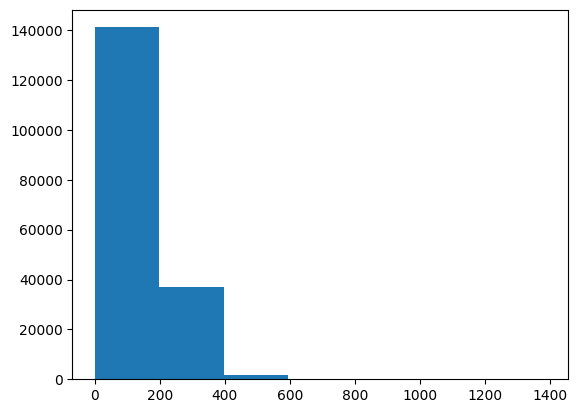

In [59]:
# check the distribution of our sequence at character level
import matplotlib.pyplot as plt 
plt.hist(chars_lens,bins=7)

In [60]:
# find what character length covers 95% of sequence 
output_seq_char_len = int(np.percentile(chars_lens,95))
output_seq_char_len

290

In [61]:
# Get all keyboard characters
random.choice(train_sentences)

import string 
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [62]:
# create char level token vectorizer instance 
# from keras.preprocessing import 

NUM_CHAR_TOKEN = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKEN,
                                    output_sequence_length=  output_seq_char_len,
                                    name = 'char_vectorizer') 


In [63]:
# adapt character vectorizer to training character 
char_vectorizer.adapt(train_chars)

In [64]:
# check character vocab stats
char_vocab =char_vectorizer.get_vocabulary()

print(f'Number of different characters in characters vocab:{len(char_vocab)}')
print(f'5 most common character: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in characters vocab:28
5 most common character: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [65]:
# test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'charified text :\n{random_train_chars}')
print(f'length of random_train_chars: {len(random_train_chars.split())}\n')

vectorized_chars = char_vectorizer([random_train_chars])
print(f'Vectorized chars:\n{vectorized_chars}')
print(f'\nlength of vectorized chars: {len(vectorized_chars[0])}')


charified text :
p a t i e n t s   w e r e   r a n d o m l y   a s s i g n e d   (   a l l o c a t i o n   r a t i o   @ : @ : @ : @ : @ : @   )   t o   r e c e i v e   e i t h e r   p l a c e b o   o r   s y r - @   a t   f i v e   d i f f e r e n t   d o s e s   (   @   m g   ,   @   m g   ,   @   m g   ,   @   m g   ,   o r   @   m g   )   .
length of random_train_chars: 129

Vectorized chars:
[[14  5  3  4  2  6  3  9 20  2  8  2  8  5  6 10  7 15 12 19  5  9  9  4
  18  6  2 10  5 12 12  7 11  5  3  4  7  6  8  5  3  4  7  3  7  8  2 11
   2  4 21  2  2  4  3 13  2  8 14 12  5 11  2 22  7  7  8  9 19  8  5  3
  17  4 21  2 10  4 17 17  2  8  2  6  3 10  7  9  2  9 15 18 15 18 15 18
  15 18  7  8 15 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0 

## Creating a character level embedding 

In [66]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim = 25,
                            #   mask_zero = True,
                              name = 'char_embed')

In [67]:
# Test out character embedding layer 
print(f'Charified text:\n {random_train_chars}')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars : \n {char_embed_example}')
print(f'character embedding shape: {char_embed_example.shape}')

Charified text:
 p a t i e n t s   w e r e   r a n d o m l y   a s s i g n e d   (   a l l o c a t i o n   r a t i o   @ : @ : @ : @ : @ : @   )   t o   r e c e i v e   e i t h e r   p l a c e b o   o r   s y r - @   a t   f i v e   d i f f e r e n t   d o s e s   (   @   m g   ,   @   m g   ,   @   m g   ,   @   m g   ,   o r   @   m g   )   .
Embedded chars : 
 [[[ 0.0291342   0.01082171 -0.04396951 ...  0.04894412 -0.00571889
    0.04088583]
  [-0.00331492  0.02088343  0.04622768 ... -0.02801346 -0.01392485
   -0.02874477]
  [ 0.00396612 -0.00909813 -0.03281762 ...  0.02779696 -0.03473228
    0.02115644]
  ...
  [-0.03167917 -0.01177951  0.01324822 ... -0.01323812  0.01057936
   -0.04105727]
  [-0.03167917 -0.01177951  0.01324822 ... -0.01323812  0.01057936
   -0.04105727]
  [-0.03167917 -0.01177951  0.01324822 ... -0.01323812  0.01057936
   -0.04105727]]]
character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit character embedding

In [68]:
# make Conv1D on chars only
inputs = layers.Input(shape=(1,),dtype='string')
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)

x = layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)

outputs = layers.Dense(num_classes,activation='softmax')(x)

model_3 = tf.keras.Model(inputs = inputs, # type: ignore
                         outputs = outputs,
                         name = 'model_3_conv1d_char_embeddings')

model_3.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(), # type: ignore
                metrics = ['accuracy'])

In [69]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [70]:
# Create char level datasets

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
# fit the model 

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs = 3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 3s 4ms/step - loss: 1.2675 - accuracy: 0.4777 - val_loss: 1.0580 - val_accuracy: 0.5781
Epoch 2/3
562/562 [==============================] - 2s 4ms/step - loss: 1.0169 - accuracy: 0.5965 - val_loss: 0.9662 - val_accuracy: 0.6147
Epoch 3/3
562/562 [==============================] - 2s 4ms/step - loss: 0.9314 - accuracy: 0.6331 - val_loss: 0.8831 - val_accuracy: 0.6536


In [72]:
# make predicitons with character only 
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.208178  , 0.42225784, 0.06484906, 0.26450315, 0.04021197],
       [0.17008826, 0.6672365 , 0.01979372, 0.09973589, 0.04314563],
       [0.12423513, 0.20683329, 0.33645505, 0.29145646, 0.04102008],
       ...,
       [0.02889003, 0.07032676, 0.15650673, 0.07146278, 0.6728137 ],
       [0.00757407, 0.05487835, 0.34563282, 0.0173545 , 0.5745603 ],
       [0.27821988, 0.5460813 , 0.10896001, 0.06095943, 0.00577941]],
      dtype=float32)

In [73]:
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 1], dtype=int64)>

In [74]:
# calculate results for Conv1d model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,y_pred=model_3_preds)
model_3_results

{'accuracy': 65.5600423672713,
 'precision': 0.6480988178251192,
 'recall': 0.6556004236727129,
 'f1': 0.644432469749743}

## Model 4: Combining pretrained token embeddding + character embeddings (Hybrid model)
1. create a token-level embedding model (similar model_1)
2. Create a character level model (similar to  model_3 with a slight modification)
3. combine 1 & 2 with a concatenate (layers.Concatenate)
4. Build a series of output on top of 3 
5. construct a model which takes token and character-level sequences as input and produces sequence label probabilites as output 

In [75]:
# # 1. Setup token inputs/model
# token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
# token_embeddings = tf_hub_embedding_layer(token_inputs)
# token_output = layers.Dense(128, activation="relu")(token_embeddings)
# token_model = tf.keras.Model(inputs=token_inputs,
#                              outputs=token_output)

# # 2. Setup char inputs/model
# char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
# char_vectors = char_vectorizer(char_inputs)
# char_embeddings = char_embed(char_vectors)
# char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
# char_model = tf.keras.Model(inputs=char_inputs,
#                             outputs=char_bi_lstm)

# # 3. Concatenate token and char inputs (create hybrid token embedding)
# token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
#                                                                   char_model.output])

# # 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
# combined_dropout = layers.Dropout(0.5)(token_char_concat)
# combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
# final_dropout = layers.Dropout(0.5)(combined_dense)
# output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# # 5. Construct model with char and token inputs
# model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
#                          outputs=output_layer,
#                          name="model_4_token_and_char_embeddings")

In [76]:

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,#type:ignore
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,#type:ignore
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout) # slightly different to Figure 1 due to different shapes of token/char embedding layers
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],#type:ignore
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [77]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 Universal_sentence_encoder  (None, 512)                  2567978 

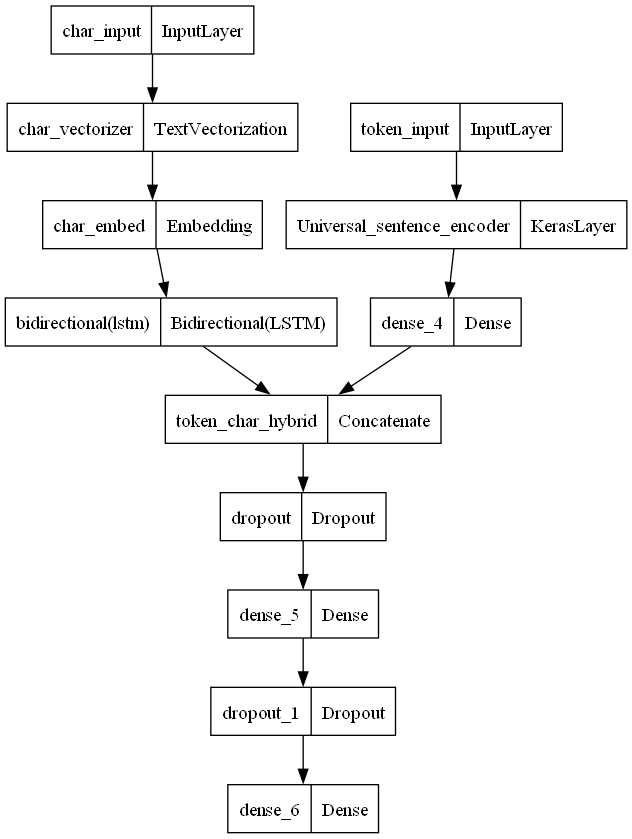

In [78]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model #type:ignore
plot_model(model_4)

In [79]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam #type:ignore
                metrics=["accuracy"])

In [80]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [81]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [82]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 26s 41ms/step - loss: 0.9750 - accuracy: 0.6089 - val_loss: 0.7906 - val_accuracy: 0.6928
Epoch 2/3
562/562 [==============================] - 22s 39ms/step - loss: 0.8006 - accuracy: 0.6919 - val_loss: 0.7220 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 22s 39ms/step - loss: 0.7707 - accuracy: 0.7038 - val_loss: 0.6960 - val_accuracy: 0.7390


In [83]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

  1/945 [..............................] - ETA: 17s - loss: 1.0293 - accuracy: 0.4688

945/945 [==============================] - 11s 12ms/step - loss: 0.6994 - accuracy: 0.7341


[0.6994123458862305, 0.7341453433036804]

In [84]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[4.4062725e-01, 3.6634824e-01, 3.9256178e-03, 1.8018471e-01,
        8.9141522e-03],
       [3.4564579e-01, 4.2901784e-01, 2.4927780e-03, 2.2117108e-01,
        1.6725515e-03],
       [3.6107108e-01, 1.6067591e-01, 4.6976611e-02, 3.9731181e-01,
        3.3964619e-02],
       ...,
       [6.9155905e-04, 7.9920581e-03, 5.5910446e-02, 2.6672220e-04,
        9.3513918e-01],
       [8.5302396e-03, 4.9356796e-02, 2.1425268e-01, 4.2726696e-03,
        7.2358757e-01],
       [2.4213398e-01, 3.8296571e-01, 2.3960163e-01, 2.7795566e-02,
        1.0750310e-01]], dtype=float32)

In [85]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1], dtype=int64)>

In [86]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.41453726995896,
 'precision': 0.7353436647672182,
 'recall': 0.7341453726995896,
 'f1': 0.7333852604109199}

In [87]:
model_1_results

{'accuracy': 78.46551039322124,
 'precision': 0.7812973027050926,
 'recall': 0.7846551039322124,
 'f1': 0.7822954645370233}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings 

In [88]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **NOTE:** Any Engineered features used to train a model need to be available at test time , in our case line numbers and total lines are available

### Create positional embeddings 

In [89]:
train_df['line_number'].value_counts()


line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

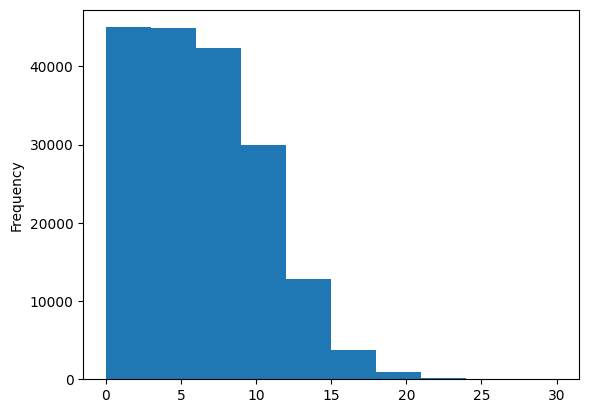

In [90]:
# check the distribution of line number column
train_df.line_number.plot.hist()

In [91]:
# use Tensorflow to create one hot encoded tensors of our 'line_numbers' column
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(),depth = 15)

train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line numbers feature , lets do the same for our total lines

In [92]:
# How many diffenrent number of lines are there 
train_df['total_lines'].value_counts()

total_lines
11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

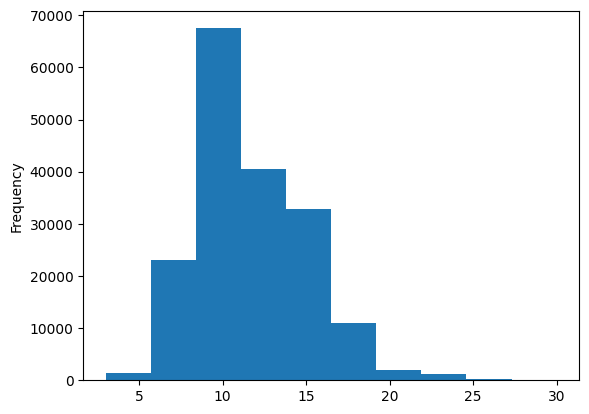

In [93]:
# Check the distribution of total lines 
train_df.total_lines.plot.hist()

In [94]:
# Check the coverage of total_lines value of 20 

np.percentile(train_df.total_lines,98)

20.0

In [95]:
# Use Tensorflow to create one-hot-encoded tensors of our total_lines feature

train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(),depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(),depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(),depth = 20)

train_total_lines_one_hot[:10] , train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

## Building a tribrid embedding model 

1. Create a token_level model
2. Create a character-level model
3. Create a model for the 'line_number' feature
4. Create a model for the 'total_lines'feature 
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate 
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embeddings and output label probabilites
8. Combine the inputs of 1,2,3,4 and outputs of into a tf.keras.Model

In [96]:
# 1. token inputs
token_inputs = layers.Input(shape=[],dtype='string',name = 'token_inputs')
token_embedings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128,activation ='relu')(token_embedings)
token_model = tf.keras.Model(inputs = token_inputs, # type: ignore
                             outputs = token_output)

# 2. Char inputs 
char_inputs = layers.Input(shape=(1,),dtype='string',name = 'char_layer')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs, # type: ignore
                            outputs = char_bi_lstm)
# 3 Line number model 
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32,name = 'line_number_input')
x = layers.Dense(32,activation ='relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs, # type: ignore
                                   outputs = x)

# 4 Total line model
total_lines_inputs = layers.Input(shape=(20,),dtype=tf.float32,name = 'total_lines_input')
y = layers.Dense(32,activation ='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, # type: ignore
                                  outputs = y)

# 5. Combine token and char embeddings into hybrid embedding 
combined_embeddings = layers.Concatenate(name ='Char_token_hybrid_embedding')([token_model.output,
                                                                               char_model.output])

z = layers.Dense(256,activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name = 'Char_token_positional_embedding')([line_number_model.output,
                                                                                   total_line_model.output,
                                                                                   z])

# 7. Create output layer 
output_layer = layers.Dense(5,activation ='softmax',name ='output_layer')(tribrid_embeddings)

# 8. put together model with all kinds of inputs 
model_5 = tf.keras.Model(inputs=[line_number_model.inputs, # type: ignore
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                        outputs = output_layer,
                        name = 'Model_5_tribrid_embedding_model')

In [97]:
model_5.summary()

Model: "Model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_layer (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_layer[0][0]']          
 rization)                                                                                        
                                                                                                  
 Universal_sentence_encoder  (None, 512)                  2567978   

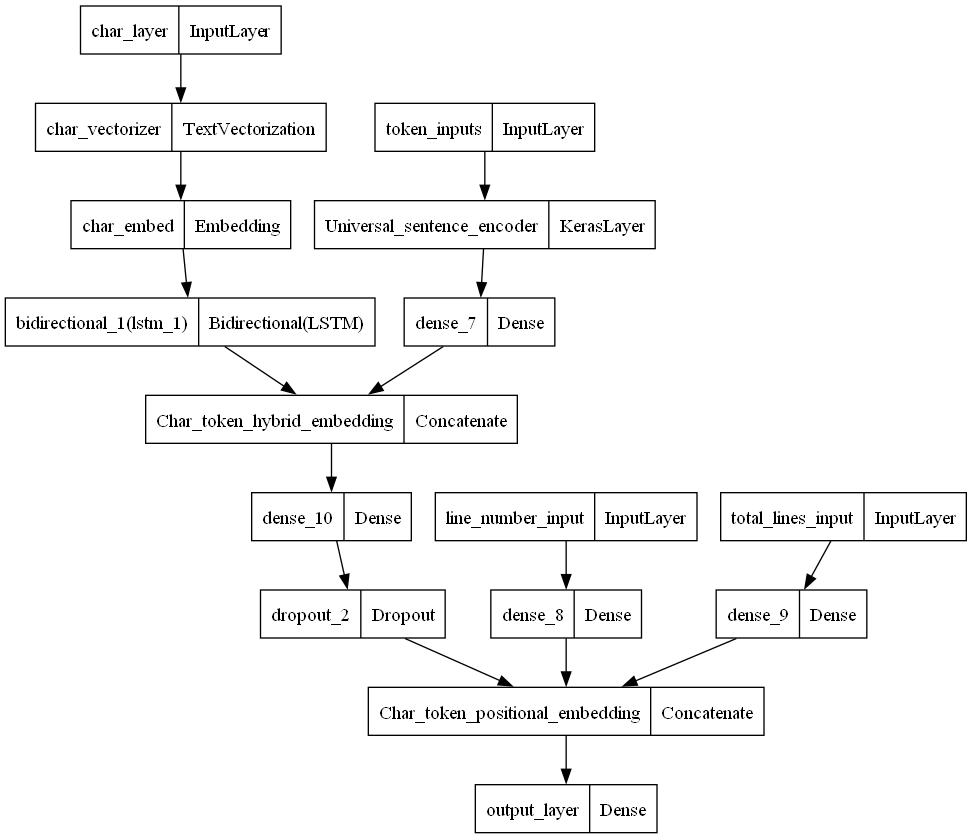

In [98]:
from tensorflow.keras.utils import plot_model #type:ignore
plot_model(model_5)

In [99]:
# compile  model_5
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # type: ignore
                optimizer = tf.keras.optimizers.Adam(), # type: ignore
                metrics = ['accuracy'])

### Create tribrid embedding datasets using tf.data

In [101]:
# Create training and valiadation datasets 
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels)) 
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# creating dataset for validation data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels)) 
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [102]:
# check input shape 
train_char_token_pos_dataset , val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting , evaluating and making predictions with out tribrid model 


In [104]:
# Fit our tribrid embedding model 
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1* len(train_char_token_pos_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 45ms/step - loss: 1.0961 - accuracy: 0.7250 - val_loss: 0.9859 - val_accuracy: 0.8042
Epoch 2/3
562/562 [==============================] - 23s 42ms/step - loss: 0.9684 - accuracy: 0.8147 - val_loss: 0.9501 - val_accuracy: 0.8291
Epoch 3/3
562/562 [==============================] - 24s 42ms/step - loss: 0.9523 - accuracy: 0.8231 - val_loss: 0.9400 - val_accuracy: 0.8331


In [105]:
# make predictions with the char token pos model 
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset,verbose=1)
model_5_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[0.47314996, 0.10213036, 0.01107408, 0.3931858 , 0.0204599 ],
       [0.49504834, 0.09591366, 0.05628259, 0.3413966 , 0.01135885],
       [0.22844113, 0.1227712 , 0.1530716 , 0.41751498, 0.0782011 ],
       ...,
       [0.03595789, 0.10166676, 0.04554826, 0.0361742 , 0.7806529 ],
       [0.02582191, 0.2648831 , 0.06796997, 0.02247023, 0.6188548 ],
       [0.20958821, 0.5651555 , 0.10937019, 0.04365172, 0.0722343 ]],
      dtype=float32)

In [106]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1], dtype=int64)>

In [108]:
# results of model_5
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred= model_5_preds )
model_5_results

{'accuracy': 83.12922017741295,
 'precision': 0.8304266289199412,
 'recall': 0.8312922017741294,
 'f1': 0.8306370628499693}

## Comparing our models results 

In [110]:
# combine model results into a dataframe 

all_model_results = pd.DataFrame({'model_0_baseline':baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embedding':model_2_results,
                                  'model_3_custom_char_embedding':model_3_results,
                                  'model_4_hybrid_char_token_embedding':model_4_results,
                                  'model_5_pos_char_token_embedding': model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.465510,0.781297,0.784655,0.782295
model_2_pretrained_token_embedding,71.431881,0.714398,0.714319,0.711293
model_3_custom_char_embedding,65.560042,0.648099,0.655600,0.644432
model_4_hybrid_char_token_embedding,73.414537,0.735344,0.734145,0.733385
model_5_pos_char_token_embedding,83.129220,0.830427,0.831292,0.830637


In [111]:
# Reduce the accuracy to same scale as other metrics 
all_model_results['accuracy'] = all_model_results['accuracy'] /100

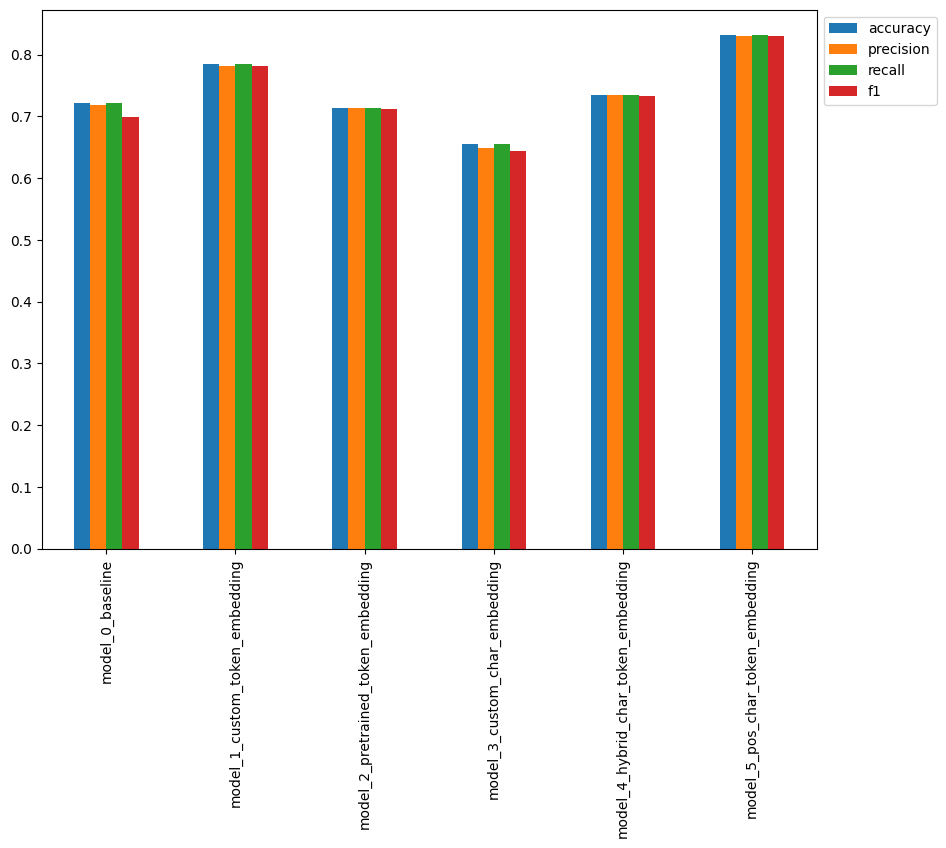

In [114]:
# plot and compare all model results 
all_model_results.plot(kind='bar',figsize=(10,7)).legend(bbox_to_anchor =(1.0,1.0))

<Axes: >

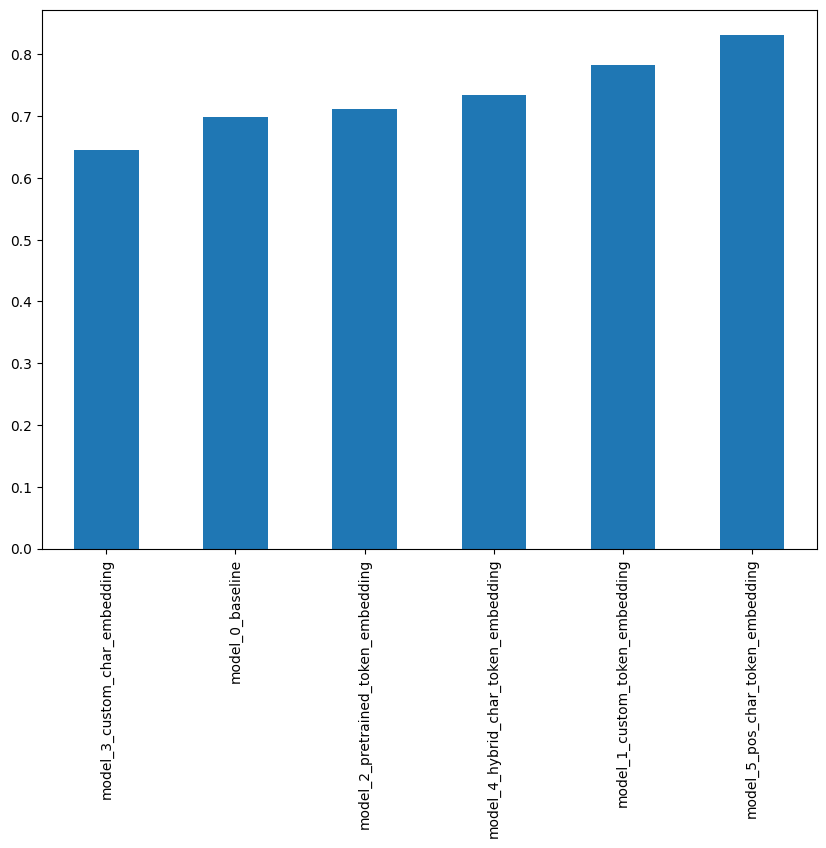

In [116]:
# Sort the model results by f1 score
all_model_results.sort_values('f1',ascending=True)['f1'].plot(kind='bar',figsize=(10,7))

## Save and load model 

In [117]:
# save the best performing model 
model_5.save('Skimlit_tribrid_model')

INFO:tensorflow:Assets written to: Skimlit_tribrid_model\assets


INFO:tensorflow:Assets written to: Skimlit_tribrid_model\assets


In [120]:
# Load in best performing model 
loaded_model = tf.keras.models.load_model('Skimlit_tribrid_model') # type: ignore


In [121]:
loaded_model.summary()

Model: "Model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_layer (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_layer[0][0]']          
 rization)                                                                                        
                                                                                                  
 Universal_sentence_encoder  (None, 512)                  2567978   

In [122]:
# make predictions with loaded model on th validation set 
loaded_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_pred_probs,axis=1)
loaded_preds[:10]

945/945 [==============================] - 13s 12ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1], dtype=int64)>

In [124]:
# calculate the results of our loaded model 
loaded_model_results = calculate_results(val_labels_encoded,
                                         loaded_preds)
loaded_model_results

{'accuracy': 83.12922017741295,
 'precision': 0.8304266289199412,
 'recall': 0.8312922017741294,
 'f1': 0.8306370628499693}

In [126]:
assert model_5_results == loaded_model_results